# Install required libraries
To install the required libraries from the requirements file, use the following command:
"pip install -r requirements.txt"

# 0. Initialization

In [88]:
import numpy as np # a library for numerical computations and handling arrays
import pandas as pd #  a library for data manipulation and analysis, often used for handling tabular data

# Visualisation Library
import matplotlib.pyplot as plt # module for data visualization through plots and charts
import seaborn as sns # a data visualization library built on Matplotlib, offering advanced plotting functions and attractive visual styles
import matplotlib.ticker as ticker
# Classification continous
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Classification Categorial
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Processing Classification
from sklearn.model_selection import train_test_split
from sklearn import metrics

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Collect the Data

In [89]:
# Load the dataset from the specified path
data = pd.read_csv("../data/G3_immobiliers.csv")

# 2. Data Cleaning and Preparation

In [90]:
# Display the first 10 rows of the dataset to understand its structure
data.head(10)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
0,2022-1343146,2022-02-04,1,Vente,420000.0,NaN,NaN,LA CADISCIE,B009,81220.0,...,NaN,NaN,T,terres,NaN,NaN,1215.0,1.950729,43.64992,0000A
1,2022-1343521,2022-01-28,1,Vente,1500.0,NaN,NaN,SERRO,B168,81260.0,...,NaN,NaN,P,prés,NaN,NaN,1000.0,2.5195,43.618791,0000C
2,2022-1343592,2022-01-28,2,Vente,105000.0,NaN,NaN,PUECH ROUGE,B026,81170.0,...,NaN,NaN,P,prés,NaN,NaN,3900.0,1.896586,44.044786,0000A
3,2022-1343732,2022-02-10,1,Vente,5000.0,NaN,NaN,FOURMENTAL,B029,81300.0,...,NaN,NaN,T,terres,NaN,NaN,2770.0,2.031586,43.697737,0000B
4,2022-1343732,2022-02-10,1,Vente,5000.0,NaN,NaN,FOURMENTAL,B029,81300.0,...,NaN,NaN,T,terres,NaN,NaN,591.0,2.031218,43.697683,0000B
5,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,1762.0,1.667288,43.859966,0000C
6,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,P,prés,NaN,NaN,5505.0,1.66712,43.85981,0000C
7,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,18.0,1.667785,43.859678,0000C
8,2022-1343755,2022-02-15,1,Vente,31500.0,NaN,NaN,MASCALE BAS,B081,81800.0,...,NaN,NaN,S,sols,NaN,NaN,70.0,1.667777,43.859631,0000C
9,2022-1343779,2022-02-11,1,Vente,173000.0,NaN,NaN,BAURUNE,B003,81120.0,...,NaN,NaN,T,terres,NaN,NaN,2022.0,2.087579,43.805298,0000D


In [91]:
# Display dataset information including column names, data types, and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146215 entries, 0 to 146214
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   id_mutation                   146215 non-null  object
 1   date_mutation                 146215 non-null  object
 2   numero_disposition            146215 non-null  object
 3   nature_mutation               146215 non-null  object
 4   valeur_fonciere               145482 non-null  object
 5   adresse_numero                67801 non-null   object
 6   adresse_suffixe               2927 non-null    object
 7   adresse_nom_voie              146142 non-null  object
 8   adresse_code_voie             146143 non-null  object
 9   code_postal                   146143 non-null  object
 10  code_commune                  146215 non-null  object
 11  nom_commune                   146215 non-null  object
 12  code_departement              146215 non-null  object
 13 

In [92]:
# Get statistical summaries of numerical columns
data.describe()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
count,146215,146215,146215,146215,145482.0,67801.0,2927,146142,146143,146143.0,...,42035.0,63503.0,134685,134685,20624,20624,134685.0,145142.000000,145142.00000,146215
unique,25492,891,15,6,7244.0,2702.0,11,12527,2290,99.0,...,945.0,32.0,22,22,27,27,14490.0,59856.000000,59338.00000,303
top,2022-1349012,2022-07-12,1,Vente,150000.0,1.0,B,LE VILLAGE,B020,81100.0,...,80.0,0.0,S,sols,FRICH,Friche,500.0,2.773587,43.64924,0000B
freq,480,933,102435,142495,1210.0,1954.0,2131,707,1016,8966.0,...,797.0,18640.0,55206,55206,5250,5250,2690.0,171.000000,171.00000,19936


In [93]:
# Check the total number of missing values in each column
data.isnull().sum()

id_mutation                          0
date_mutation                        0
numero_disposition                   0
nature_mutation                      0
valeur_fonciere                    733
adresse_numero                   78414
adresse_suffixe                 143288
adresse_nom_voie                    73
adresse_code_voie                   72
code_postal                         72
code_commune                         0
nom_commune                          0
code_departement                     0
ancien_code_commune             146205
ancien_nom_commune              146205
id_parcelle                          0
ancien_id_parcelle              146205
numero_volume                   145960
lot1_numero                     135814
lot1_surface_carrez             142818
lot2_numero                     143440
lot2_surface_carrez             145473
lot3_numero                     145396
lot3_surface_carrez             145931
lot4_numero                     146035
lot4_surface_carrez      

In [94]:
# Drop unnecessary columns that are not useful for predictive modeling
df_data = data[["valeur_fonciere", "date_mutation",  # Price and transaction date
    "code_postal", "code_commune", "nom_commune", "code_departement",  # Location
    "type_local", "surface_reelle_bati", "nombre_pieces_principales",  # Goods characteristics
    "surface_terrain", "nature_culture"  # Land characteristics
]]

In [95]:
# Convert "valeur_fonciere" column to numeric, forcing errors to NaN
df_data["valeur_fonciere"] = pd.to_numeric(df_data["valeur_fonciere"], errors="coerce")
# Remove rows where "valeur_fonciere" is missing
df_data = df_data.dropna(subset=["valeur_fonciere"])

In [96]:
# Convert "surface_reelle_bati" column to numeric, forcing errors to NaN
df_data["surface_reelle_bati"] = pd.to_numeric(df_data["surface_reelle_bati"], errors="coerce")
# Remove rows where "surface_reelle_bati" is missing
df_data = df_data.dropna(subset=["surface_reelle_bati"])

In [97]:
# Remove rows with more than 50% missing values
df_data = df_data.dropna(thresh=len(df_data.columns) * 0.5)

In [98]:
# Fill missing values in numerical columns with the median
# Convert numerical columns to float type (forcing errors to NaN)
cols_num = ["surface_reelle_bati", "surface_terrain", "nombre_pieces_principales", "valeur_fonciere"]
for col in cols_num:
    df_data[col] = pd.to_numeric(df_data[col], errors="coerce")  # Convert to float
    df_data[col] = df_data[col].fillna(df_data[col].median())  # Replace NaN with median

In [99]:
# Fill missing values in categorical columns with "Unknown"
cols_cat = ["type_local", "nature_culture"]
for col in cols_cat:
    df_data[col] = df_data[col].fillna("Unknown")

In [100]:
# Convert categorical variables into dummy/indicator variables (One-Hot Encoding)
df_data = pd.get_dummies(df_data, columns=["type_local", "nature_culture"], drop_first=True)

In [101]:
# Display the first 10 rows after cleaning and transformation
df_data.head(10)

,valeur_fonciere,date_mutation,code_postal,code_commune,nom_commune,code_departement,surface_reelle_bati,nombre_pieces_principales,surface_terrain,type_local_Local industriel. commercial ou assimilé,...,nature_culture_peupleraies,nature_culture_prés,nature_culture_sols,nature_culture_taillis simples,nature_culture_taillis sous futaie,nature_culture_terrains a bâtir,nature_culture_terrains d'agrément,nature_culture_terres,nature_culture_vergers,nature_culture_vignes
60,185000.0,2022-05-16,81320.0,81193,Nages,81,28.0,3.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False
61,185000.0,2022-05-16,81320.0,81193,Nages,81,666.0,0.0,1310.0,True,...,False,False,False,False,False,False,True,False,False,False
62,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False
63,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False
64,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False
65,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False
66,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,2.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False
67,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,3.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False
68,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,3.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False
69,185000.0,2022-05-16,81320.0,81193,Nages,81,29.0,3.0,1310.0,False,...,False,False,False,False,False,False,True,False,False,False


In [103]:
# Convert 'code_postal' to string
df_data["code_postal"] = df_data["code_postal"].astype(str)

In [143]:
# Deleting null values
df_data = df_data[(df_data["surface_reelle_bati"] > 0) & (df_data["valeur_fonciere"] > 0)]

In [146]:
# Display dataset information after cleaning and transformation
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41798 entries, 60 to 146212
Data columns (total 26 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   valeur_fonciere                                      41798 non-null  float64
 1   date_mutation                                        41798 non-null  object 
 2   code_postal                                          41798 non-null  object 
 3   code_commune                                         41798 non-null  object 
 4   nom_commune                                          41798 non-null  object 
 5   code_departement                                     41798 non-null  object 
 6   surface_reelle_bati                                  41798 non-null  float64
 7   nombre_pieces_principales                            41798 non-null  float64
 8   surface_terrain                                      41798 non-null  

# 3. Distribution of real estate prices

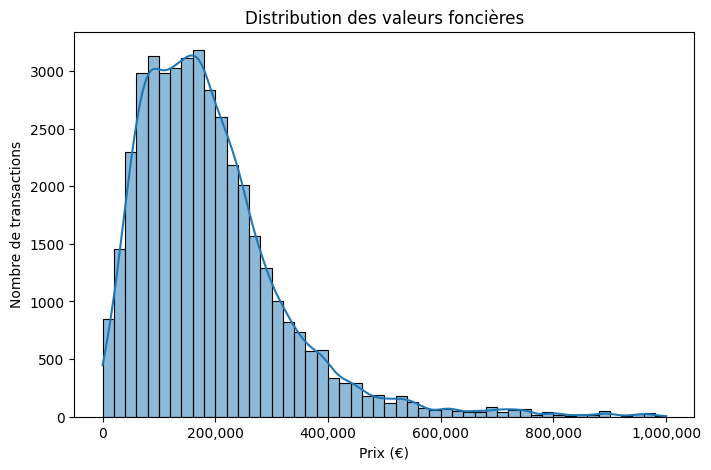

In [116]:
# Distribution of real estate prices
plt.figure(figsize=(8, 5))
sns.histplot(df_data[df_data.valeur_fonciere <= 1e6].valeur_fonciere, bins=50, kde=True)
plt.title("Distribution des valeurs foncières")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de transactions")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))
plt.show()

# 4. Visualization of the Relationship between Area and Price by Property Type

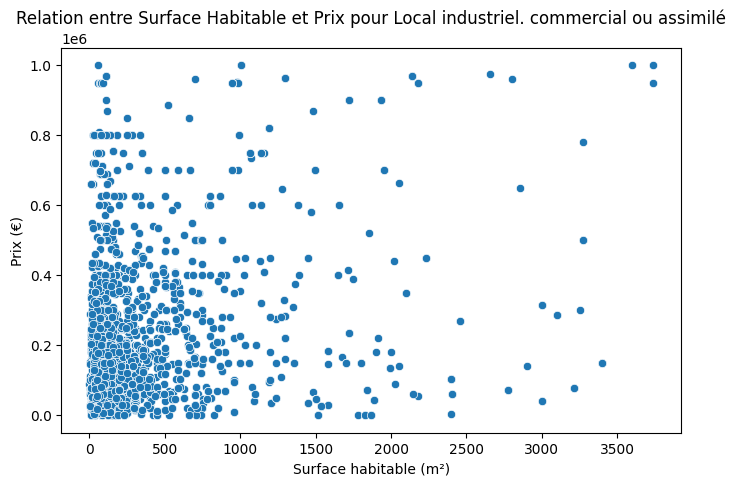

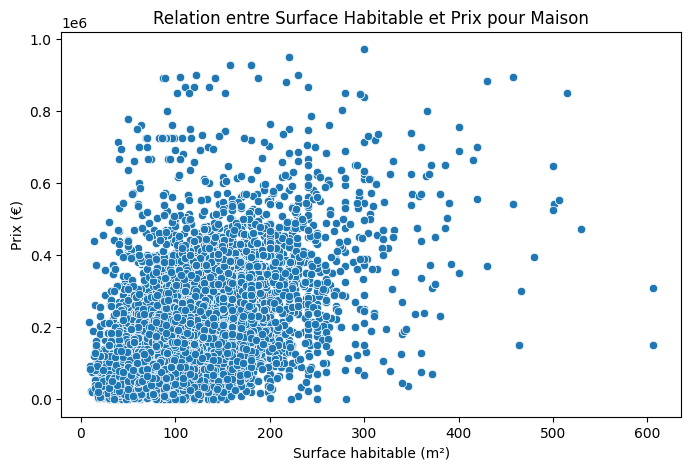

In [117]:
# Get unique property types
unique_types = df_data.columns[df_data.columns.str.startswith("type_local_")]

# Create a separate chart for each property type
for type_col in unique_types:
    type_name = type_col.replace("type_local_", "")  # Extract the property type name
    subset = df_data[(df_data[type_col] == 1) & (df_data.surface_reelle_bati <= 4000) & (df_data.valeur_fonciere <= 1e6)]  # Filtrer les données

    # Check if the subset contains data
    if not subset.empty:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=subset.surface_reelle_bati, y=subset.valeur_fonciere)
        plt.title(f"Relation entre Surface Habitable et Prix pour {type_name}")
        plt.xlabel("Surface habitable (m²)")
        plt.ylabel("Prix (€)")
        plt.show()

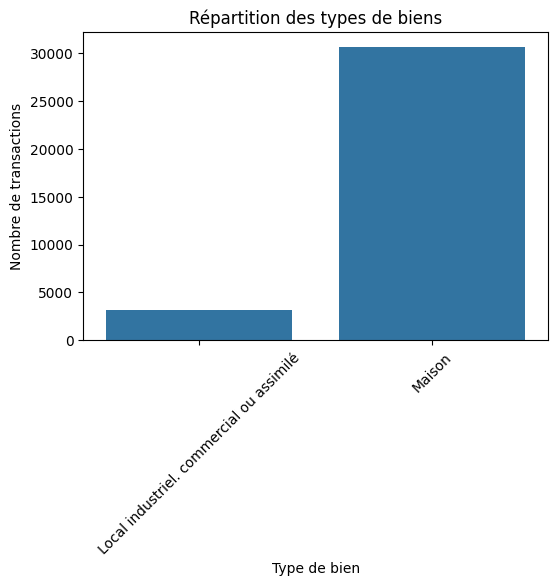

In [118]:
# Distribution of property types
plt.figure(figsize=(6, 4))

# Extract the names of property types
type_local_columns = [col for col in df_data.columns if col.startswith("type_local_")]

# Count the number of occurrences for each property type
type_counts = {col.replace("type_local_", ""): df_data[col].sum() for col in type_local_columns}

# Create a DataFrame for visualization
df_type_counts = pd.DataFrame.from_dict(type_counts, orient="index", columns=["count"]).reset_index()
df_type_counts.rename(columns={"index": "type_local"}, inplace=True)

# Plot the chart
sns.barplot(x="type_local", y="count", data=df_type_counts)
plt.title("Répartition des types de biens")
plt.xticks(rotation=45)
plt.xlabel("Type de bien")
plt.ylabel("Nombre de transactions")
plt.show()


# 5. Data modelisation

In [119]:
# Features selection
features = ["surface_reelle_bati", "surface_terrain", "nombre_pieces_principales", "code_postal"] + [col for col in df_data.columns if col.startswith("type_local_")]

# Encode only the 'code_postal' column if necessary
data_encoded = pd.get_dummies(df_data[features], columns=["code_postal"], drop_first=True)

X = data_encoded
y = df_data["valeur_fonciere"]

# Split the data into training and test sets (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluation
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"Decision Tree - MAE : {mae_tree:.2f} € | R² : {r2_tree:.2f}")

Decision Tree - MAE : 91632.22 € | R² : 0.20


In [120]:
# Initialize and train the Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE : {mae_rf:.2f} € | R² : {r2_rf:.2f}")

Random Forest - MAE : 74413.71 € | R² : 0.50


# 6. Evaluate the importance of each feature

In [121]:
importances = rf_model.feature_importances_
feature_names = X.columns
# Convert into DataFrame
df_importances = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Group the values of postal codes and property types
df_importances["Feature"] = df_importances["Feature"].replace({r"code_postal_.*": "code_postal", 
                                                                r"type_local_.*": "type_local"}, regex=True)

# Average importance by grouped category
df_grouped = df_importances.groupby("Feature")["Importance"].sum().reset_index()

# Sort and display the results
df_grouped = df_grouped.sort_values(by="Importance", ascending=False)
print(df_grouped)


                     Feature  Importance
2        surface_reelle_bati    0.406142
3            surface_terrain    0.280372
0                code_postal    0.237665
1  nombre_pieces_principales    0.040744
4                 type_local    0.035077


# 7. Searching for better parameters to optimize the Random Forest

In [122]:
# Define the grid of parameters to test
param_grid = {
    'n_estimators': [100,200], 
    'max_depth': [10, 20], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Start the search for the best parameters
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Meilleurs paramètres :", grid_search.best_params_)

# Recalculate the model with the best parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# New evaluation
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"Optimized Random Forest - MAE : {mae_best:.2f} € | R² : {r2_best:.2f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest - MAE : 56739.97 € | R² : 0.65


In [124]:
# Enhanced Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, min_samples_split=2, min_samples_leaf=1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE : {mae_rf:.2f} € | R² : {r2_rf:.2f}")

Random Forest - MAE : 56739.97 € | R² : 0.65


# 8. Analyze and visualize the results

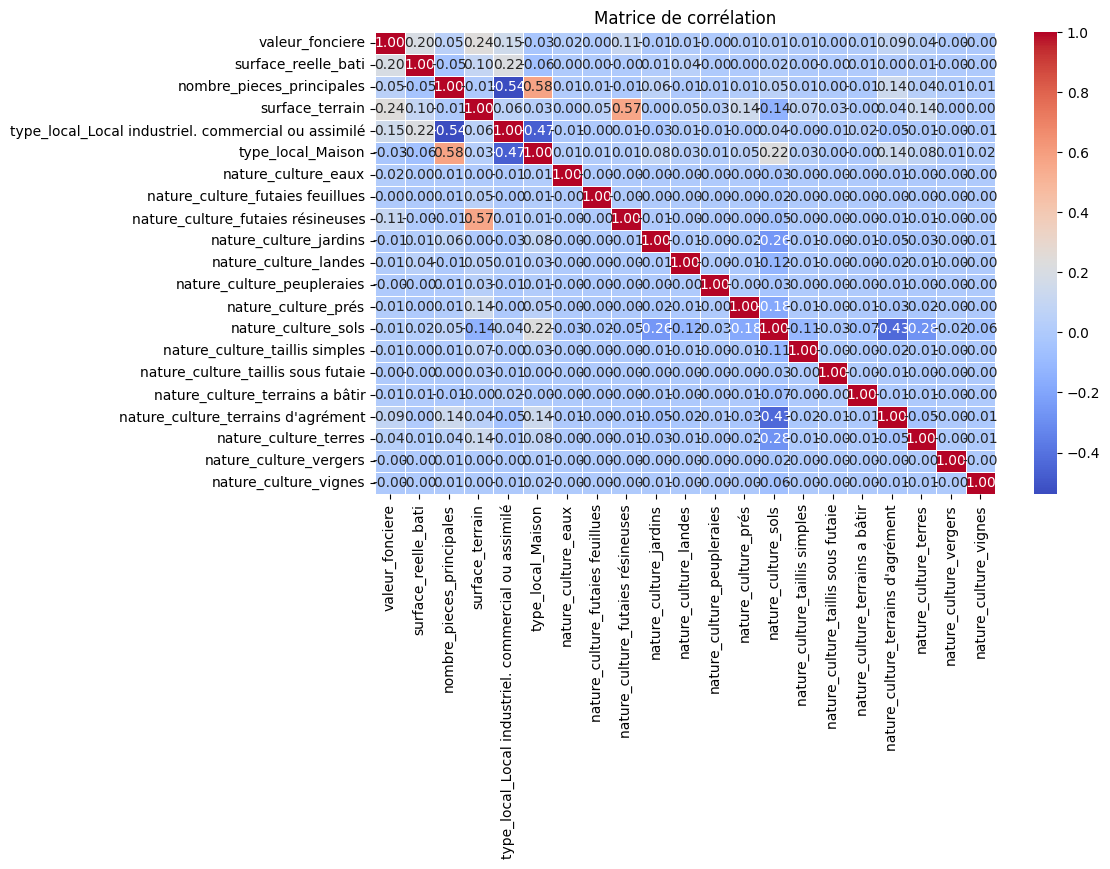

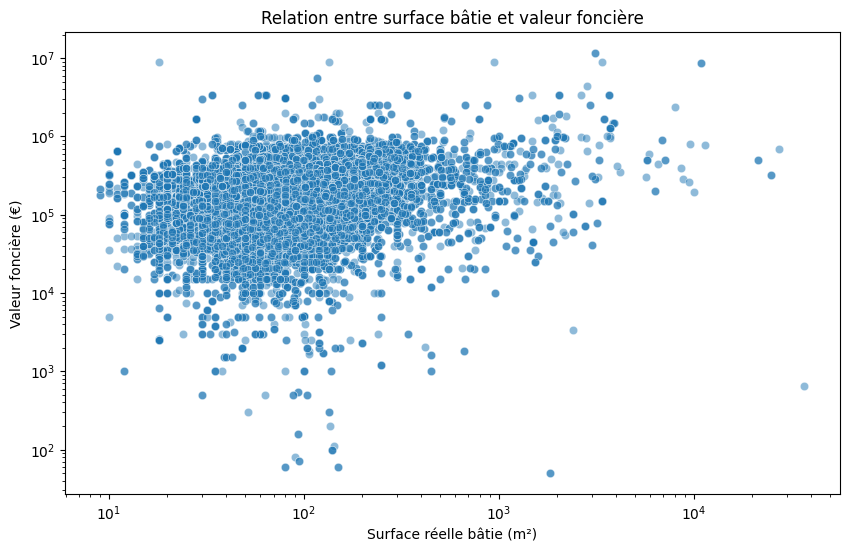

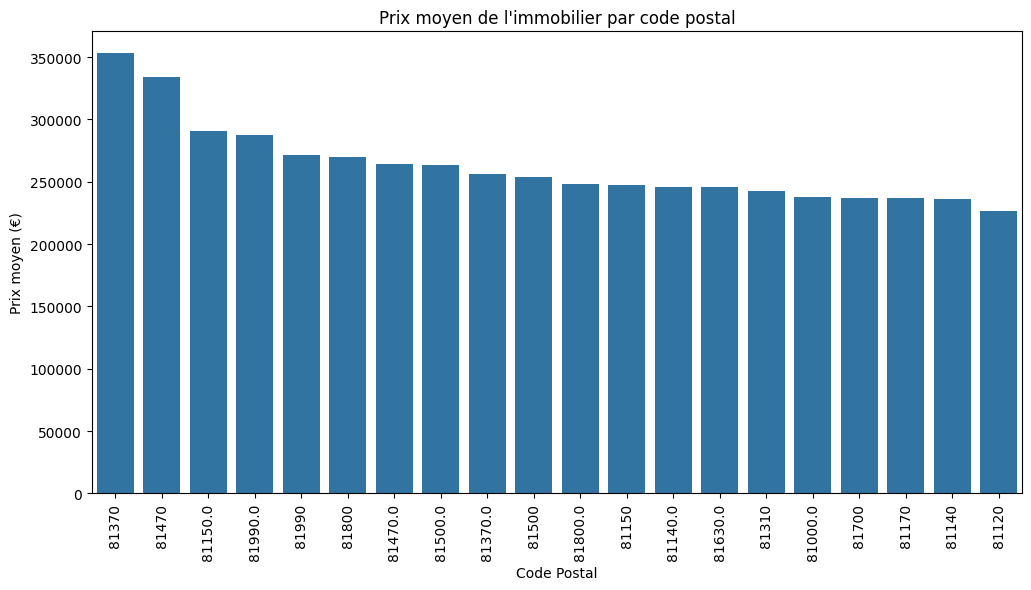

In [145]:
# Correlation matrix
plt.figure(figsize=(10, 6))
corr = df_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

# Relationship between built-up area and land value
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_data['surface_reelle_bati'], y=df_data['valeur_fonciere'], alpha=0.5)
plt.xscale('log')  # Échelle log pour mieux visualiser les tendances
plt.yscale('log')
plt.title('Relation entre surface bâtie et valeur foncière')
plt.xlabel('Surface réelle bâtie (m²)')
plt.ylabel('Valeur foncière (€)')
plt.show()

# Average price by postal code
plt.figure(figsize=(12, 6))
code_postal_moy = df_data.groupby('code_postal')['valeur_fonciere'].mean().sort_values(ascending=False)[:20]
sns.barplot(x=code_postal_moy.index, y=code_postal_moy.values)
plt.xticks(rotation=90)
plt.title("Prix moyen de l'immobilier par code postal")
plt.xlabel('Code Postal')
plt.ylabel('Prix moyen (€)')
plt.show()
